In [8]:
import pandas as pd
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination



In [25]:
df = pd.read_csv("~/Projects/School/fourth_year/CS3346/CS3346Project/1_Recipe_csv.csv")

# Creation Prior Table
df["is_italian"] = df["category"] == "Italian"
P_italian = df["is_italian"].mean()
prior_italian = pd.DataFrame({
    "Italian": ["Yes", "No"],
    "P(Italian)": [P_italian, 1 - P_italian]
})
prior_italian

,Italian,P(Italian)
0,Yes,0.012475
1,No,0.987525


In [59]:

# Computing CPT for Tomato & Italian Relationship
df["uses_tomato"] = df["ingredients"].str.lower().str.contains("tomato")
N = len(df)

cpt_tomato = pd.DataFrame({
    "Italian": ["0","0","1", "1"],
    "Tomato": ["0", "1", "0", "1"],
    "P(Tomato | Italian)": [
        1 - df[~df["is_italian"]]["uses_tomato"].mean(),
        1 - df[df["is_italian"]]["uses_tomato"].mean(),
        df[~df["is_italian"]]["uses_tomato"].mean(), 
        df[df["is_italian"]]["uses_tomato"].mean(), 
    ],
})

cpt_tomato

,Italian,Tomato,P(Tomato | Italian)
0,0,0,0.875226
1,0,1,0.660645
2,1,0,0.124774
3,1,1,0.339355


In [72]:
# Computing CPT for Simple Recipe & Italian Relationship

df["simple_recipe"] = df["num_ingredients"] <= 7
N = len(df)

cpt_simple = pd.DataFrame({
    "Italian": ["0","0","1", "1"],
    "Simple": ["0", "1", "0", "1"],
    "P(Simple | Italian)": [
        1 - df[~df["is_italian"]]["simple_recipe"].mean(),
        1 - df[df["is_italian"]]["simple_recipe"].mean(),
        df[~df["is_italian"]]["simple_recipe"].mean(), 
        df[df["is_italian"]]["simple_recipe"].mean(), 
    ],
})

cpt_simple

,Italian,Simple,P(Simple | Italian)
0,0,0,0.618735
1,0,1,0.649032
2,1,0,0.381265
3,1,1,0.350968


In [85]:
# computing CPT for Steps & Simple
df["fast"] = df["num_steps"] <= 6
N = len(df)

cpt_fast = pd.DataFrame({
    "Simple": ["0","0","1", "1"],
    "Fast": ["0", "1", "0", "1"],
    "P(Fast | Simple)": [
        1 - df[~df["simple_recipe"]]["fast"].mean(),
        1 - df[df["simple_recipe"]]["fast"].mean(),
        df[~df["simple_recipe"]]["fast"].mean(), 
        df[df["simple_recipe"]]["fast"].mean(), 
    ],
})

cpt_fast


,Simple,Fast,P(Fast | Simple)
0,0,0,0.213634
1,0,1,0.137768
2,1,0,0.786366
3,1,1,0.862232


In [108]:
# Large CPT for P(I|T,S)
grouped = (
    df.groupby(["uses_tomato", "simple_recipe"])["is_italian"]
      .mean() 
      .reset_index(name="P_I1")
)

rows = []

for _, row in grouped.iterrows():
    T = int(row["uses_tomato"])
    S = int(row["simple_recipe"])
    p1 = float(row["P_I1"])
    p0 = 1 - p1

    rows.append({"Tomato": T, "Simple": S, "Italian": 0, "P(I|T,S)": p0})
    rows.append({"Tomato": T, "Simple": S, "Italian": 1, "P(I|T,S)": p1})

cpt = pd.DataFrame(rows)
cpt



,Tomato,Simple,Italian,"P(I|T,S)"
0,0,0,0,0.990803
1,0,0,1,0.009197
2,0,1,0,0.990210
3,0,1,1,0.009790
4,1,0,0,0.969269
5,1,0,1,0.030731
6,1,1,0,0.949341
7,1,1,1,0.050659


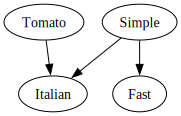

In [89]:
import graphviz
g = Digraph()
g.node("I", "Italian")
g.node("T", "Tomato")
g.node("S", "Simple")
g.node("F", "Fast")


g.edge("T", "I")
g.edge("S", "I")
g.edge("S", "F")


g


In [105]:
from sympy import symbols, Eq
from sympy import init_printing
init_printing()

Eq(symbols('P(TSIF)'), symbols('P(S)')*symbols('P(T)')*symbols('P(I|TS)')*symbols('P(F|S)'))

# Eq(symbols('P(T,S,I,F)'), symbols('P(T)')*symbols("P(S)P(I∣T,S)P(F∣S)"))
